# Milestone 4 - Extension - Aspect-Based Sentiment Analysis
**Team Members:** Nick Cirillo, Suha Memon, Kalen Truong, Bruce Zhang

**Date:** December 2025

---

## Overview
This notebook contains the complete implementation for one Milestone 4 extension, Aspect-Based Sentiment Analysis.


---

## Installation & Setup

Install all required packages.

In [1]:
# Install required packages
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn tqdm accelerate -q

print("All packages installed successfully!")

All packages installed successfully!


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# HuggingFace imports
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


## Exploring FIQA Dataset

In [3]:
from datasets import load_dataset

# Load FiQA dataset from HuggingFace
fiqa_dataset = load_dataset("pauri32/fiqa-2018")

# Explore the structure
print("Dataset structure:")
print(fiqa_dataset)

print("\n" + "="*50)
print("Available splits:")
print(fiqa_dataset.keys())

print("\n" + "="*50)
print("Column names:")
print(fiqa_dataset['train'].column_names)

print("\n" + "="*50)
print("First 3 examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(fiqa_dataset['train'][i])

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/961 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/102 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/150 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label'],
        num_rows: 961
    })
    validation: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label'],
        num_rows: 102
    })
    test: Dataset({
        features: ['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label'],
        num_rows: 150
    })
})

Available splits:
dict_keys(['train', 'validation', 'test'])

Column names:
['sentence', 'snippets', 'target', 'sentiment_score', 'aspects', 'format', 'label']

First 3 examples:

Example 1:
{'sentence': 'Still short $LNG from $11.70 area...next stop could be down through $9.00. Someone slammed it hard with 230,000 shs this am! More to follow', 'snippets': "['Still short $LNG from $11.70 area...next stop could be down through $9.00.']", 'target': 'LNG', 'sentiment_score': -0.543, 'aspects': "['S

## Explore Level-1 Aspects

In [5]:
import ast

# Extract Level-1 aspects from the training set
def extract_level1_aspect(aspects_str):
    """Extract the first-level aspect from the aspects string."""
    try:
        # Parse the string representation of list
        aspects_list = ast.literal_eval(aspects_str)
        if aspects_list:
            # Get first aspect, split by '/', take first part
            return aspects_list[0].split('/')[0]
    except:
        return None
    return None

# Apply to training data
level1_aspects = [extract_level1_aspect(ex['aspects']) for ex in fiqa_dataset['train']]

# Count distribution
from collections import Counter
aspect_counts = Counter(level1_aspects)

print("Level-1 Aspect Distribution (Training Set):")
print("="*50)
for aspect, count in sorted(aspect_counts.items(), key=lambda x: -x[1]):
    pct = count / len(level1_aspects) * 100
    aspect_name = aspect if aspect is not None else "NONE/MISSING"
    print(f"{aspect_name:15} : {count:4} ({pct:.1f}%)")

print(f"\nTotal examples: {len(level1_aspects)}")
print(f"Unique Level-1 aspects: {len(aspect_counts)}")

Level-1 Aspect Distribution (Training Set):
Stock           :  562 (58.5%)
Corporate       :  367 (38.2%)
Market          :   26 (2.7%)
Economy         :    4 (0.4%)
NONE/MISSING    :    2 (0.2%)

Total examples: 961
Unique Level-1 aspects: 5


## Configuration & File Paths


In [9]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)

# Define the path to your project folder within Google Drive, assuming it's a shortcut
# If it's a direct folder, the path might be '/content/drive/MyDrive/NLP Group Project'
# Given it's a shortcut, it's typically found under /content/drive/MyDrive/ and then the shortcut name
project_path = '/content/drive/MyDrive/NLP Group Project'
# project_path = '/content/drive/MyDrive/CIS5300: NLP/NLP Group Project'
# Check if the project path exists. If it's a shortcut, Colab often resolves it under 'MyDrive'.
if not os.path.exists(project_path):
    print(f"Warning: Project path '{project_path}' not found. Please verify the shortcut name and location.")
    print("Attempting to check for a direct folder in MyDrive...")
    project_path = '/content/drive/MyDrive/NLP Group Project'
    if not os.path.exists(project_path):
        print(f"Error: Direct project path '{project_path}' also not found. Please adjust 'project_path' variable.")
    else:
        print("Found project folder as a direct folder in MyDrive.")
else:
    print(f"Found project folder at '{project_path}'.")

# Change current working directory to the project path
# This ensures relative paths for data files work correctly
if os.path.exists(project_path):
    os.chdir(project_path)
    print(f"Current working directory changed to: {os.getcwd()}")
else:
    print("Could not change directory. Please fix the 'project_path'.")

print("Google Drive mounted and directory setup complete.")

Mounted at /content/drive
Found project folder at '/content/drive/MyDrive/NLP Group Project'.
Current working directory changed to: /content/drive/MyDrive/NLP Group Project
Google Drive mounted and directory setup complete.


In [34]:
!ls

logs  models  output


In [11]:
# Output directories
OUTPUT_DIR = 'output'
MODEL_DIR = 'models/finbert_fiqa_aspect'

# Create directories if they don't exist
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs('logs', exist_ok=True)

# Model configuration
MODEL_NAME = "ProsusAI/finbert"  # Can also use "yiyanghkust/finbert-tone"
NUM_LABELS = 4
MAX_LENGTH = 128

# Label mapping
LABEL_NAMES = ['Corporate', 'Economy', 'Market', 'Stock']
LABEL_MAP = {0: 'Corporate', 1: 'Economy', 2: 'Market', 3: 'Stock'}
ASPECT_TO_LABEL = {'Corporate': 0, 'Economy': 1, 'Market': 2, 'Stock': 3}

print("Configuration set!")
print(f"Task: FiQA Level-1 Aspect Classification")
print(f"Number of classes: {NUM_LABELS}")
print(f"Classes: {LABEL_NAMES}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Configuration set!
Task: FiQA Level-1 Aspect Classification
Number of classes: 4
Classes: ['Corporate', 'Economy', 'Market', 'Stock']
Output directory: output
Model directory: models/finbert_fiqa_aspect


## Data Exploration

Exploring our dataset to understand the class distribution.

In [12]:
import ast
import pandas as pd

def extract_level1_aspect(aspects_str):
    """Extract the first-level aspect from the aspects string."""
    try:
        aspects_list = ast.literal_eval(aspects_str)
        if aspects_list:
            return aspects_list[0].split('/')[0]
    except:
        return None
    return None

def fiqa_to_dataframe(dataset_split):
    """Convert a FiQA dataset split to a pandas DataFrame matching our expected format."""
    rows = []
    for example in dataset_split:
        aspect = extract_level1_aspect(example['aspects'])
        # Skip examples with missing aspects or aspects not in our label set
        if aspect is not None and aspect in ASPECT_TO_LABEL:
            rows.append({
                'Sentence': example['sentence'],
                'Sentiment': aspect,  # Using 'Sentiment' column name to match original format
                'label': ASPECT_TO_LABEL[aspect]
            })
    return pd.DataFrame(rows)

# Convert all splits
print("Converting FiQA dataset to DataFrames...")
train_df = fiqa_to_dataframe(fiqa_dataset['train'])
dev_df = fiqa_to_dataframe(fiqa_dataset['validation'])
test_df = fiqa_to_dataframe(fiqa_dataset['test'])

print(f"Training samples: {len(train_df)}")
print(f"Development samples: {len(dev_df)}")
print(f"Test samples: {len(test_df)}")

print("\nSample data:")
print(train_df.head())

Converting FiQA dataset to DataFrames...
Training samples: 959
Development samples: 102
Test samples: 149

Sample data:
                                            Sentence  Sentiment  label
0  Still short $LNG from $11.70 area...next stop ...      Stock      3
1                                    $PLUG bear raid      Stock      3
2  How Kraft-Heinz Merger Came Together in Speedy...  Corporate      0
3     Slump in Weir leads FTSE down from record high     Market      2
4                $AAPL bounces off support, it seems      Stock      3


In [13]:
# Class distribution analysis
def analyze_class_distribution(df, dataset_name):
    class_counts = df['label'].value_counts().sort_index()

    print(f"\n{dataset_name} Class Distribution:")
    print("=" * 50)
    for label, count in class_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{LABEL_MAP[label]:>8} ({label}): {count:>5} ({percentage:>5.2f}%)")

    return class_counts

train_dist = analyze_class_distribution(train_df, "Training")
dev_dist = analyze_class_distribution(dev_df, "Development")
test_dist = analyze_class_distribution(test_df, "Test")


Training Class Distribution:
Corporate (0):   367 (38.27%)
 Economy (1):     4 ( 0.42%)
  Market (2):    26 ( 2.71%)
   Stock (3):   562 (58.60%)

Development Class Distribution:
Corporate (0):    51 (50.00%)
 Economy (1):     1 ( 0.98%)
  Market (2):     4 ( 3.92%)
   Stock (3):    46 (45.10%)

Test Class Distribution:
Corporate (0):    64 (42.95%)
 Economy (1):     3 ( 2.01%)
  Market (2):     8 ( 5.37%)
   Stock (3):    74 (49.66%)


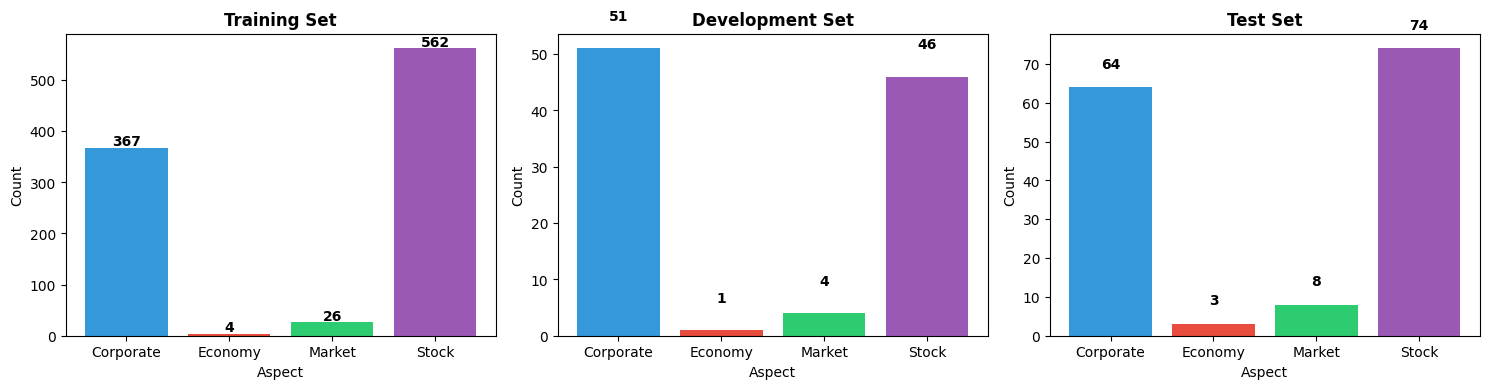

Visualization saved to output/fiqa_aspect_distribution.png


In [14]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (df, title) in enumerate([(train_df, 'Training'),
                                     (dev_df, 'Development'),
                                     (test_df, 'Test')]):
    class_counts = df['label'].value_counts().sort_index()
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']  # Blue, Red, Green, Purple for 4 classes

    axes[idx].bar([LABEL_MAP[i] for i in class_counts.index],
                  class_counts.values,
                  color=[colors[i] for i in class_counts.index])
    axes[idx].set_title(f'{title} Set', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xlabel('Aspect')

    # Add count labels on bars
    for i, (label, count) in enumerate(zip(class_counts.index, class_counts.values)):
        axes[idx].text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/fiqa_aspect_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {OUTPUT_DIR}/fiqa_aspect_distribution.png")

In [16]:
# Sample headlines from each class
print("\nSample Headlines by Sentiment:")
print("=" * 80)

for label in [0, 1, 2, 3]:
    print(f"\n{LABEL_MAP[label].upper()} Examples:")
    samples = train_df[train_df['label'] == label].sample(min(3, len(train_df[train_df['label'] == label])), random_state=SEED)
    for idx, row in samples.iterrows():
        print(f"  • {row['Sentence'][:100]}..." if len(row['Sentence']) > 100 else f"  • {row['Sentence']}")


Sample Headlines by Sentiment:

CORPORATE Examples:
  • Chime Communications Set To Be Acquired By WPP And Providence
  • HSBC appoints business leaders to board
  • Bilfinger Industrial Services win ÃÂ£100m BP contract extension

ECONOMY Examples:
  • Standard Chartered, RBS Escape Capital Raising in Stress Test
  • 2 Turnaround Buys For 2016? BHP Billiton plc And Home Retail Group Plc
  • StanChart and RBS struggle in Bank of England stress tests

MARKET Examples:
  • $STX move off the bottom but still in bear market #datasecurity $EMC $SNDK $WDC https://t.co/VkYdWPx...
  • FTSE led lower by M&S, GlaxoSmithKline
  • Slump in Weir leads FTSE down from record high

STOCK Examples:
  • $GS is looking weak while this market is moving higher not a good sign. Unless $gs can get above 157...
  • $NUGT longer term bullish
  • Added. Cost now at 1.54. Bounce off of Put OI & S1 pivot. @moteltan BTO $AAPL Apr 27 2012 605.0 Call...


---
# Component 1: Evaluation Script

We'll implement our evaluation metrics: Accuracy, F1-Macro, and F1-Weighted.

## Evaluation Metrics Implementation

In [32]:
def evaluate_predictions(predictions, gold_labels, verbose=True):
    """
    Evaluate predictions against gold standard labels.

    Args:
        predictions: Array of predicted labels (0, 1, 2)
        gold_labels: Array of true labels (0, 1, 2)
        verbose: Whether to print detailed results

    Returns:
        Dictionary containing all metrics
    """
    # Calculate metrics
    accuracy = accuracy_score(gold_labels, predictions)
    f1_macro = f1_score(gold_labels, predictions, average='macro')
    f1_weighted = f1_score(gold_labels, predictions, average='weighted')

    # Per-class metrics
    f1_per_class = f1_score(gold_labels, predictions, average=None)

    # Confusion matrix
    cm = confusion_matrix(gold_labels, predictions)

    if verbose:
        print("=" * 70)
        print("EVALUATION RESULTS")
        print("=" * 70)
        print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"F1-Score (Macro):  {f1_macro:.4f}")
        print(f"F1-Score (Weighted): {f1_weighted:.4f}")

        print("\n" + "=" * 70)
        print("PER-CLASS METRICS")
        print("=" * 70)

        # Detailed classification report
        print(classification_report(
            gold_labels,
            predictions,
            target_names=LABEL_NAMES,
            digits=4
        ))

        print("=" * 70)
        print("CONFUSION MATRIX")
        print("=" * 70)
        print("Rows: True Labels | Columns: Predicted Labels\n")
        print("           Corporate  Economy  Market  Stock")
        for i, row in enumerate(cm):
            print(f"{LABEL_NAMES[i]:>8}   {row[0]:>5}    {row[1]:>5}    {row[2]:>5}    {row[3]:>5}")

    results = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm
    }

    return results

print("Evaluation function defined!")

Evaluation function defined!


In [18]:
def plot_confusion_matrix(cm, title='Confusion Matrix', save_path=None):
    """
    Plot a confusion matrix heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=LABEL_NAMES,
        yticklabels=LABEL_NAMES,
        cbar_kws={'label': 'Count'}
    )
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")

    plt.show()

print("Visualization function defined!")

Visualization function defined!


## Data Preparation for FinBERT

In [19]:
def prepare_dataset_for_training(df):
    """
    Convert pandas DataFrame to HuggingFace Dataset.

    Args:
        df: DataFrame with 'Sentence' and 'Label' columns

    Returns:
        HuggingFace Dataset object
    """
    # Rename columns to match trainer expectations
    df_copy = df.copy()
    df_copy = df_copy.rename(columns={'Sentence': 'text', 'label': 'label'})

    # Convert to HuggingFace Dataset
    dataset = Dataset.from_pandas(df_copy[['text', 'label']])

    return dataset

print("Preparing datasets for training...")
train_dataset = prepare_dataset_for_training(train_df)
dev_dataset = prepare_dataset_for_training(dev_df)
test_dataset = prepare_dataset_for_training(test_df)

print(f"Train dataset: {len(train_dataset)} examples")
print(f"Dev dataset: {len(dev_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

print("\nExample from training set:")
print(train_dataset[0])

Preparing datasets for training...
Train dataset: 959 examples
Dev dataset: 102 examples
Test dataset: 149 examples

Example from training set:
{'text': 'Still short $LNG from $11.70 area...next stop could be down through $9.00. Someone slammed it hard with 230,000 shs this am! More to follow', 'label': 3}


## Load FinBERT Model & Tokenizer

In [20]:
print("=" * 70)
print("LOADING FINBERT MODEL & TOKENIZER")
print("=" * 70)

print(f"\n Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f" Tokenizer loaded! Vocab size: {len(tokenizer)}")

print(f"\nLoading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)

print(f" Model loaded!")
print(f" Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f" Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Using device: {device}")

LOADING FINBERT MODEL & TOKENIZER

 Loading tokenizer: ProsusAI/finbert


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

 Tokenizer loaded! Vocab size: 30522

Loading model: ProsusAI/finbert


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded!
 Model parameters: 109,485,316
 Trainable parameters: 109,485,316

 Using device: cuda


## Tokenize Data

In [21]:
def tokenize_function(examples):
    """
    Tokenize text inputs.
    """
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

print("Tokenizing datasets...")
print("This may take a minute...\n")

train_tokenized = train_dataset.map(tokenize_function, batched=True)
dev_tokenized = dev_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

print("Tokenization complete!")

# Show tokenization example
print("\nTokenization Example:")
print(f"Original text: {train_dataset[0]['text'][:100]}...")
print(f"Tokenized (first 20 tokens): {train_tokenized[0]['input_ids'][:20]}")
print(f"Decoded back: {tokenizer.decode(train_tokenized[0]['input_ids'][:20])}")

Tokenizing datasets...
This may take a minute...



Map:   0%|          | 0/959 [00:00<?, ? examples/s]

Map:   0%|          | 0/102 [00:00<?, ? examples/s]

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Tokenization complete!

Tokenization Example:
Original text: Still short $LNG from $11.70 area...next stop could be down through $9.00. Someone slammed it hard w...
Tokenized (first 20 tokens): [101, 2145, 2460, 1002, 1048, 3070, 2013, 1002, 2340, 1012, 3963, 2181, 1012, 1012, 1012, 2279, 2644, 2071, 2022, 2091]
Decoded back: [CLS] still short $ lng from $ 11. 70 area... next stop could be down


## Define Training Configuration

In [22]:
def compute_metrics(eval_pred):
    """
    Compute metrics during training/evaluation.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

# Training arguments
training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,  # Only keep best 2 checkpoints
    report_to="none"  # Disable wandb/tensorboard
)

print("=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Learning rate: {training_args.learning_rate}")
print(f"Batch size (train): {training_args.per_device_train_batch_size}")
print(f"Batch size (eval): {training_args.per_device_eval_batch_size}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Weight decay: {training_args.weight_decay}")
print(f"Optimization metric: {training_args.metric_for_best_model}")
# print(f"Early stopping patience: 2 epochs")
print("=" * 70)

TRAINING CONFIGURATION
Learning rate: 2e-05
Batch size (train): 16
Batch size (eval): 32
Number of epochs: 5
Weight decay: 0.01
Optimization metric: f1_macro


## Class Weighting

This approach addresses class imbalance in the FIQA dataset by applying inverse frequency weighting to the loss function. The model assigns higher weights to underrepresented classes during training, forcing it to pay more attention to minority class examples (especially Economic sentiment).

In [24]:
def compute_class_weights(labels):
    """Compute inverse frequency class weights"""
    class_counts = np.bincount(labels)
    total = len(labels)
    weights = total / (len(class_counts) * class_counts)
    return torch.FloatTensor(weights)

class_weights = compute_class_weights(train_df['label'].values)
print("\n" + "=" * 50)
print("CLASS WEIGHTS (for handling imbalance)")
print("=" * 50)
for i, weight in enumerate(class_weights):
    print(f"{LABEL_MAP[i]:>8}: {weight:.4f}")
print("=" * 50)


CLASS WEIGHTS (for handling imbalance)
Corporate: 0.6533
 Economy: 59.9375
  Market: 9.2212
   Stock: 0.4266


In [25]:
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply class weights to loss
        loss_fct = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device)
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [26]:
# Using the saem training datasets and tokenized data as above:
print(f"Train dataset: {len(train_dataset)} examples")
print(f"Dev dataset: {len(dev_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")
print("\nTokenization Example:")
print(f"Original text: {train_dataset[0]['text'][:100]}...")
print(f"Tokenized (first 20 tokens): {train_tokenized[0]['input_ids'][:20]}")
print(f"Decoded back: {tokenizer.decode(train_tokenized[0]['input_ids'][:20])}")

Train dataset: 959 examples
Dev dataset: 102 examples
Test dataset: 149 examples

Tokenization Example:
Original text: Still short $LNG from $11.70 area...next stop could be down through $9.00. Someone slammed it hard w...
Tokenized (first 20 tokens): [101, 2145, 2460, 1002, 1048, 3070, 2013, 1002, 2340, 1012, 3963, 2181, 1012, 1012, 1012, 2279, 2644, 2071, 2022, 2091]
Decoded back: [CLS] still short $ lng from $ 11. 70 area... next stop could be down


In [27]:
# IMPROVED Training arguments
improved_training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,  # INCREASED from 2e-5
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,  # INCREASED from 5
    weight_decay=0.01,
    warmup_ratio=0.1,  # NEW: warmup steps
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    seed=SEED,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    gradient_accumulation_steps=2,  # NEW: effective batch size = 32
    max_grad_norm=1.0,  # NEW: gradient clipping
    fp16=torch.cuda.is_available(),  # NEW: mixed precision training
)

print("\n" + "=" * 70)
print("IMPROVED TRAINING CONFIGURATION")
print("=" * 70)
print(f"Learning rate: {improved_training_args.learning_rate}")
print(f"Batch size (train): {improved_training_args.per_device_train_batch_size}")
print(f"Gradient accumulation: {improved_training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {improved_training_args.per_device_train_batch_size * improved_training_args.gradient_accumulation_steps}")
print(f"Batch size (eval): {improved_training_args.per_device_eval_batch_size}")
print(f"Number of epochs: {improved_training_args.num_train_epochs}")
print(f"Weight decay: {improved_training_args.weight_decay}")
print(f"Warmup ratio: {improved_training_args.warmup_ratio}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Dropout: 0.2")
print(f"Gradient clipping: {improved_training_args.max_grad_norm}")
print(f"Mixed precision: {improved_training_args.fp16}")
print(f"Optimization metric: {improved_training_args.metric_for_best_model}")
print(f"Early stopping patience: 3 epochs")
print(f"CLASS WEIGHTING: ENABLED")
print("=" * 70)


IMPROVED TRAINING CONFIGURATION
Learning rate: 3e-05
Batch size (train): 16
Gradient accumulation: 2
Effective batch size: 32
Batch size (eval): 32
Number of epochs: 10
Weight decay: 0.01
Warmup ratio: 0.1
Max sequence length: 128
Dropout: 0.2
Gradient clipping: 1.0
Mixed precision: True
Optimization metric: f1_macro
Early stopping patience: 3 epochs
CLASS WEIGHTING: ENABLED


In [28]:
print("\n" + "=" * 70)
print("RELOADING FRESH MODEL FOR IMPROVED TRAINING")
print("=" * 70)

model_improved = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True
)

# Add dropout
model_improved.config.hidden_dropout_prob = 0.2
model_improved.config.attention_probs_dropout_prob = 0.2

print("✓ Fresh model loaded for improved training")

# Then use model_improved instead of model
improved_trainer = WeightedLossTrainer(
    model=model_improved,
    args=improved_training_args,
    train_dataset=train_tokenized,
    eval_dataset=dev_tokenized,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    class_weights=class_weights
)

print("\n" + "=" * 70)
print("STARTING TRAINING - IMPROVED MODEL")
print("=" * 70)

# Train the model
improved_train_result = improved_trainer.train()

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"Training time: {improved_train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples/second: {improved_train_result.metrics['train_samples_per_second']:.2f}")



RELOADING FRESH MODEL FOR IMPROVED TRAINING


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Fresh model loaded for improved training

STARTING TRAINING - IMPROVED MODEL


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,1.285158,0.686275,0.484211,0.686550
2,1.162600,0.966515,0.852941,0.574010,0.859746
3,1.162600,0.725331,0.921569,0.665523,0.917436
4,0.649100,0.536053,0.941176,0.721743,0.936500
5,0.296500,0.409992,0.970588,0.737302,0.965889
6,0.296500,0.361902,0.980392,0.742138,0.975538
7,0.158000,0.292817,0.980392,0.717048,0.976029
8,0.158000,0.269627,0.990196,0.747312,0.985347
9,0.072200,0.231196,1.000000,1.000000,1.000000
10,0.067000,0.221615,1.000000,1.000000,1.000000



TRAINING COMPLETE!
Training time: 199.87 seconds
Training samples/second: 47.98


In [29]:
# EVALUATE ON DEVELOPMENT SET

print("\n" + "=" * 70)
print("EVALUATING ON DEVELOPMENT SET")
print("=" * 70 + "\n")

dev_results_improved = improved_trainer.evaluate()

print("\nDevelopment Set Results:")
print("=" * 70)
print(f"Accuracy:          {dev_results_improved['eval_accuracy']:.4f} ({dev_results_improved['eval_accuracy']*100:.2f}%)")
print(f"F1-Score (Macro):  {dev_results_improved['eval_f1_macro']:.4f}")
print(f"F1-Score (Weighted): {dev_results_improved['eval_f1_weighted']:.4f}")
print("=" * 70)


EVALUATING ON DEVELOPMENT SET




Development Set Results:
Accuracy:          1.0000 (100.00%)
F1-Score (Macro):  1.0000
F1-Score (Weighted): 1.0000


In [30]:
# GENERATE TEST PREDICTIONS

print("\n" + "=" * 70)
print("GENERATING TEST SET PREDICTIONS")
print("=" * 70 + "\n")

predictions_improved_output = improved_trainer.predict(test_tokenized)
improved_predictions = np.argmax(predictions_improved_output.predictions, axis=-1)

print(f"Generated {len(improved_predictions)} predictions")

# Show some examples
print("\nSample Predictions:")
print("=" * 70)
for i in range(min(10, len(test_df))):
    text = test_df.iloc[i]['Sentence'][:80] + "..." if len(test_df.iloc[i]['Sentence']) > 80 else test_df.iloc[i]['Sentence']
    pred = LABEL_MAP[improved_predictions[i]]
    true = LABEL_MAP[test_df.iloc[i]['label']]
    correct = "CORRECT" if pred == true else "INCORRECT"
    print(f"{correct} Text: {text}")
    print(f"  Predicted: {pred}, True: {true}\n")


GENERATING TEST SET PREDICTIONS



Generated 149 predictions

Sample Predictions:
CORRECT Text: $HCP Come to the party and buy this -gonna give solid gains and a dividend $$$$$...
  Predicted: Corporate, True: Corporate

CORRECT Text: @gakrum nice chart shows distinctive down channel not a dip.. where do you see t...
  Predicted: Stock, True: Stock

INCORRECT Text: Japan's Asahi to submit bid next week for SABMiller's Grolsch and Peroni - Yomiu...
  Predicted: Corporate, True: Stock

CORRECT Text: Tesla Motors recalls 2,700 Model X SUVs $TSLA https://t.co/F55dx4aegI
  Predicted: Corporate, True: Corporate

INCORRECT Text: CRH's concrete bid for Holcim Lafarge assets
  Predicted: Corporate, True: Stock

CORRECT Text: Doubts grow over GlaxoSmithKline's $6 bln capital return plan
  Predicted: Corporate, True: Corporate

CORRECT Text: $XLF http://stks.co/1KJ9 Bounced off target buy area, bought $skf as a hedge. wa...
  Predicted: Stock, True: Stock

CORRECT Text: $TSLA looking good..i'd love to see a basing action here, let


EVALUATING IMPROVED MODEL ON TEST SET

EVALUATION RESULTS
Accuracy:          0.8859 (88.59%)
F1-Score (Macro):  0.5429
F1-Score (Weighted): 0.8688

PER-CLASS METRICS
              precision    recall  f1-score   support

   Corporate     0.9091    0.9375    0.9231        64
     Economy     0.0000    0.0000    0.0000         3
      Market     0.5000    0.2500    0.3333         8
       Stock     0.8861    0.9459    0.9150        74

    accuracy                         0.8859       149
   macro avg     0.5738    0.5334    0.5429       149
weighted avg     0.8574    0.8859    0.8688       149

CONFUSION MATRIX
Rows: True Labels | Columns: Predicted Labels

           Corporate  Economy  Market  Stock
Corporate      60        0        0        4
 Economy       1        0        2        0
  Market       1        0        2        5
   Stock       4        0        0       70

Predictions saved to output/improved_strong_baseline_predictions.csv
Confusion matrix saved to output/improved_

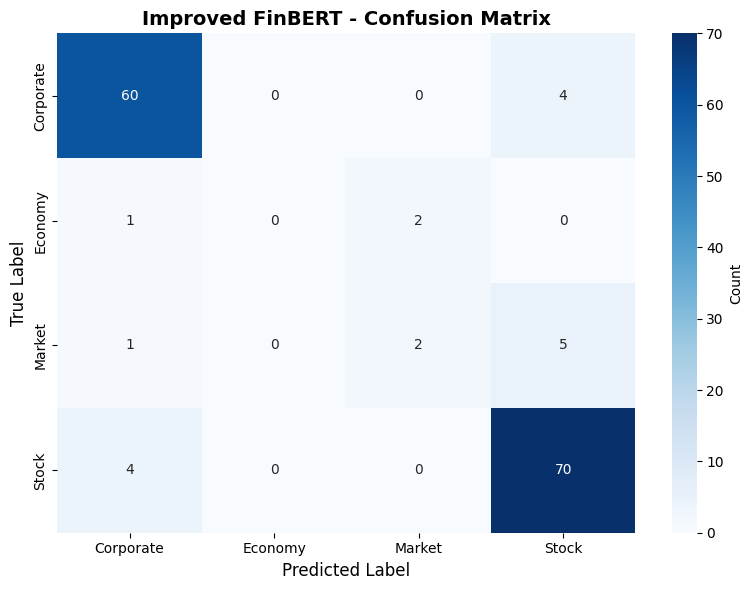

In [33]:
# EVALUATE ON TEST SET

print("\n" + "=" * 70)
print("EVALUATING IMPROVED MODEL ON TEST SET")
print("=" * 70 + "\n")

improved_results = evaluate_predictions(
    improved_predictions,
    test_df['label'].values,
    verbose=True
)

# Save predictions
improved_output_df = pd.DataFrame({
    'Sentence': test_df['Sentence'],
    'Predicted': improved_predictions,
    'Gold': test_df['label']
})
improved_output_path = f'{OUTPUT_DIR}/improved_strong_baseline_predictions.csv'
improved_output_df.to_csv(improved_output_path, index=False)
print(f"\nPredictions saved to {improved_output_path}")

# Visualize confusion matrix
plot_confusion_matrix(
    improved_results['confusion_matrix'],
    title='Improved FinBERT - Confusion Matrix',
    save_path=f'{OUTPUT_DIR}/improved_confusion_matrix.png'
)